<a href="https://colab.research.google.com/github/umiSirya/Weather_Prediction_capstone_project/blob/main/weather(UV_index)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [414]:
!pip install category_encoders

# **UV Predictor & SPF Guide**

Excessive sun exposure can lead to skin damage, premature aging, and even skin cancer. To stay protected, it’s essential to use the right sunscreen based on the **UV index**. This project combines **machine learning** with a **sunscreen recommendation system** to help users make informed decisions.  

By predicting the **UV index** based on weather data, the system recommends the most suitable **SPF level** and **sunscreen brand** to ensure optimal skin protection. With an easy-to-use **Streamlit interface**, users can enter their city, get real-time UV predictions, and receive personalized sunscreen suggestions.  

This project aims to promote **sun safety** through **AI-driven recommendations**, making it easier for users to choose the best sun protection anytime, anywhere. ☀️✨

# **Data Sourcing**
The **weather data** used in this project is sourced from a **weather API**, ensuring real-time and accurate UV index predictions based on the user's location.

link:https://www.weatherapi.com/

As for the **sunscreen data**, I personally collected and curated a list of sunscreens along with their **SPF ratings**, ensuring a diverse selection for different UV exposure levels. This combination allows the system to provide **reliable and personalized sunscreen recommendations** for optimal sun protection.

In [415]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import math
import sklearn
import xgboost


import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


**Getting Weather Data**

In [416]:
import requests
import csv

# API Key
API_KEY = "4091f433030f47658ea85020253001"

# List of major cities in Kenya
kenyan_cities = [
    "Nairobi", "Mombasa", "Kisumu", "Nakuru", "Eldoret", "Malindi", "Thika",
    "Kitale", "Garissa", "Kakamega", "Kericho", "Lamu", "Meru", "Nyeri",
    "Embu", "Voi", "Machakos", "Bomet", "Kisii", "Bungoma", "Siaya",
    "Homa Bay", "Kisumu", "Lodwar", "Taveta", "Kitui", "Murang'a",
    "Isiolo", "Mwingi", "Ruiru", "Kiambu", "Nandi Hills", "Samburu",
    "Chuka", "Kendu Bay", "Wajir", "Mandera", "Marsabit", "Baringo",
    "Taita", "Nyamira", "Laikipia", "Trans Nzoia", "Kajiado"
]

# File name for CSV output
filename = "kenya_weather_data.csv"

# Open CSV file and write headers
with open(filename, mode="w", newline="") as file:
    writer = csv.writer(file)

    # Writing header row
    headers = [
        "City", "Country", "Latitude", "Longitude", "Local Time",
        "Temperature (°C)", "Feels Like (°C)", "Humidity (%)", "Pressure (mb)",
        "Wind Speed (km/h)", "Wind Direction", "UV Index", "Visibility (km)", "Weather Condition",
        "Air Quality Index (US)", "PM2.5", "PM10", "CO (Carbon Monoxide)", "NO2 (Nitrogen Dioxide)", "SO2 (Sulfur Dioxide)",
        "Tomorrow's Max Temp (°C)", "Tomorrow's Min Temp (°C)", "Tomorrow's Condition", "Sunrise", "Sunset"
    ]
    writer.writerow(headers)

    # Loop through each city and fetch weather data
    for city in kenyan_cities:
        try:
            URL = f"http://api.weatherapi.com/v1/forecast.json?key={API_KEY}&q={city}&days=3&aqi=yes"
            response = requests.get(URL)
            data = response.json()

            # Extract comprehensive weather details
            weather_data = [
                data["location"]["name"],
                data["location"]["country"],
                data["location"]["lat"],
                data["location"]["lon"],
                data["location"]["localtime"],

                # Current Weather
                data["current"]["temp_c"],
                data["current"]["feelslike_c"],
                data["current"]["humidity"],
                data["current"]["pressure_mb"],
                data["current"]["wind_kph"],
                data["current"]["wind_dir"],
                data["current"]["uv"],
                data["current"]["vis_km"],
                data["current"]["condition"]["text"],

                # Air Quality Data
                data["current"]["air_quality"].get("us-epa-index", "N/A"),
                data["current"]["air_quality"].get("pm2_5", "N/A"),
                data["current"]["air_quality"].get("pm10", "N/A"),
                data["current"]["air_quality"].get("co", "N/A"),
                data["current"]["air_quality"].get("no2", "N/A"),
                data["current"]["air_quality"].get("so2", "N/A"),

                # Forecast (Next Day)
                data["forecast"]["forecastday"][1]["day"]["maxtemp_c"],
                data["forecast"]["forecastday"][1]["day"]["mintemp_c"],
                data["forecast"]["forecastday"][1]["day"]["condition"]["text"],
                data["forecast"]["forecastday"][1]["astro"]["sunrise"],
                data["forecast"]["forecastday"][1]["astro"]["sunset"],
            ]

            # Write data row
            writer.writerow(weather_data)
            print(f"✅ Weather data for {city} saved.")

        except Exception as e:
            print(f"❌ Error fetching data for {city}: {e}")

print(f"\n🎉 Comprehensive weather data for Kenya saved to {filename} successfully!")


✅ Weather data for Nairobi saved.
✅ Weather data for Mombasa saved.
✅ Weather data for Kisumu saved.
✅ Weather data for Nakuru saved.
✅ Weather data for Eldoret saved.
✅ Weather data for Malindi saved.
✅ Weather data for Thika saved.
✅ Weather data for Kitale saved.
✅ Weather data for Garissa saved.
✅ Weather data for Kakamega saved.
✅ Weather data for Kericho saved.
✅ Weather data for Lamu saved.
✅ Weather data for Meru saved.
✅ Weather data for Nyeri saved.
✅ Weather data for Embu saved.
✅ Weather data for Voi saved.
✅ Weather data for Machakos saved.
✅ Weather data for Bomet saved.
✅ Weather data for Kisii saved.
✅ Weather data for Bungoma saved.
✅ Weather data for Siaya saved.
✅ Weather data for Homa Bay saved.
✅ Weather data for Kisumu saved.
✅ Weather data for Lodwar saved.
✅ Weather data for Taveta saved.
✅ Weather data for Kitui saved.
✅ Weather data for Murang'a saved.
✅ Weather data for Isiolo saved.
✅ Weather data for Mwingi saved.
✅ Weather data for Ruiru saved.
✅ Weather d

**Sunscreen data**

In [417]:
import csv

# List of sunscreens with their SPF ratings
sunscreens = [
    ["Neutrogena Ultra Sheer Dry-Touch Sunscreen", 100],
    ["EltaMD UV Clear Broad-Spectrum Sunscreen", 46],
    ["Supergoop! Unseen Sunscreen", 40],
    ["La Roche-Posay Anthelios Melt-in Milk Sunscreen", 60],
    ["CeraVe Hydrating Mineral Sunscreen", 30],
    ["Banana Boat Ultra Sport Sunscreen", 50],
    ["Hawaiian Tropic Sheer Touch Lotion Sunscreen", 30],
    ["Blue Lizard Sensitive Mineral Sunscreen", 50],
    ["Coppertone Sport Sunscreen Spray", 50],
    ["Aveeno Protect + Hydrate Sunscreen", 60],
    ["Bioré UV Aqua Rich Watery Essence", 50],
    ["Sun Bum Original Sunscreen Lotion", 50],
    ["Shiseido Ultimate Sun Protector Lotion", 50],
    ["Thinkbaby Safe Sunscreen", 50],
    ["Coola Classic Face Sunscreen", 30],
    ["Australian Gold Botanical Sunscreen Tinted Face", 50],
    ["Eucerin Daily Hydration Sunscreen", 30],
    ["Babo Botanicals Clear Zinc Sunscreen", 30],
    ["ISDIN Eryfotona Actinica Mineral Sunscreen", 50],
    ["Alba Botanica Hawaiian Sunscreen", 45],
    ["Vanicream Sunscreen Sport", 35],
    ["Paula’s Choice Resist Super-Light Daily Wrinkle Defense", 30],
    ["Innisfree Daily UV Defense Sunscreen", 36],
    ["Badger Clear Zinc Sunscreen Cream", 40],
    ["Derma E Sun Defense Mineral Oil-Free Sunscreen", 30],
    ["Dr. Jart+ Every Sun Day Mineral Sunscreen", 50],
    ["Black Girl Sunscreen", 30],
    ["MD Solar Sciences Mineral Crème Sunscreen", 50],
    ["Peter Thomas Roth Water Drench Broad Spectrum Sunscreen", 45],
    ["Alastin HydraTint Pro Mineral Sunscreen", 36]
]

# Save as a CSV file
filename = "sunscreens.csv"
with open(filename, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Sunscreen Name", "SPF"])
    writer.writerows(sunscreens)

print(f"CSV file '{filename}' has been created successfully!")


CSV file 'sunscreens.csv' has been created successfully!


In [418]:
# Load sunscreen data
sunscreens= pd.read_csv("sunscreens.csv")
sunscreens.head()

,Sunscreen Name,SPF
0,Neutrogena Ultra Sheer Dry-Touch Sunscreen,100
1,EltaMD UV Clear Broad-Spectrum Sunscreen,46
2,Supergoop! Unseen Sunscreen,40
3,La Roche-Posay Anthelios Melt-in Milk Sunscreen,60
4,CeraVe Hydrating Mineral Sunscreen,30


In [419]:
sunscreens.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Sunscreen Name  30 non-null     object
 1   SPF             30 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 612.0+ bytes


In [420]:
# Load the dataset
df = pd.read_csv("kenya_weather_data.csv")
df.head()

,City,Country,Latitude,Longitude,Local Time,Temperature (°C),Feels Like (°C),Humidity (%),Pressure (mb),Wind Speed (km/h),...,PM2.5,PM10,CO (Carbon Monoxide),NO2 (Nitrogen Dioxide),SO2 (Sulfur Dioxide),Tomorrow's Max Temp (°C),Tomorrow's Min Temp (°C),Tomorrow's Condition,Sunrise,Sunset
0,Nairobi,Kenya,-1.2833,36.8167,2025-02-17 16:33,28.3,26.3,35,1020.0,25.9,...,15.725,16.835,412.55,1.850,3.885,28.4,15.0,Sunny,06:42 AM,06:51 PM
1,Mombasa,Kenya,-4.0500,39.6667,2025-02-17 16:26,32.1,37.8,52,1008.0,30.2,...,25.160,32.375,247.90,1.665,6.475,30.8,23.9,Patchy rain nearby,06:28 AM,06:42 PM
2,Kisumu,Kenya,-0.1000,34.7500,2025-02-17 16:29,32.1,30.2,34,1011.0,3.6,...,11.100,12.210,355.20,0.740,0.740,33.6,18.7,Sunny,06:51 AM,06:58 PM
3,Nakuru,Kenya,-0.2833,36.0667,2025-02-17 16:29,29.2,27.1,16,1008.0,24.8,...,10.545,11.470,281.20,0.555,0.740,28.5,10.5,Sunny,06:46 AM,06:53 PM
4,Eldoret,Kenya,0.5167,35.2833,2025-02-17 16:30,27.2,25.4,18,1021.0,27.0,...,9.805,10.915,290.45,0.555,0.555,27.7,13.0,Sunny,06:50 AM,06:56 PM


# **Exploratory Data Analysis**

In [421]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   City                      42 non-null     object 
 1   Country                   42 non-null     object 
 2   Latitude                  42 non-null     float64
 3   Longitude                 42 non-null     float64
 4   Local Time                42 non-null     object 
 5   Temperature (°C)          42 non-null     float64
 6   Feels Like (°C)           42 non-null     float64
 7   Humidity (%)              42 non-null     int64  
 8   Pressure (mb)             42 non-null     float64
 9   Wind Speed (km/h)         42 non-null     float64
 10  Wind Direction            42 non-null     object 
 11  UV Index                  42 non-null     float64
 12  Visibility (km)           42 non-null     float64
 13  Weather Condition         42 non-null     object 
 14  Air Quality 

In [422]:
sunscreens.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Sunscreen Name  30 non-null     object
 1   SPF             30 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 612.0+ bytes


In [423]:
df.describe()

,Latitude,Longitude,Temperature (°C),Feels Like (°C),Humidity (%),Pressure (mb),Wind Speed (km/h),UV Index,Visibility (km),Air Quality Index (US),PM2.5,PM10,CO (Carbon Monoxide),NO2 (Nitrogen Dioxide),SO2 (Sulfur Dioxide),Tomorrow's Max Temp (°C),Tomorrow's Min Temp (°C)
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.0,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,-0.649648,36.440771,29.971429,28.950000,32.880952,1010.333333,18.264286,4.266667,10.0,1.357143,14.808810,18.200476,294.942857,0.876548,1.246548,30.771429,16.216667
std,10.599948,26.660281,5.595655,5.861917,15.794723,5.262229,7.966540,1.707039,0.0,0.532890,6.262329,16.269329,61.730750,0.958296,1.546234,5.764961,5.743498
min,-41.200000,-46.850000,3.100000,1.800000,13.000000,1003.000000,3.600000,0.000000,10.0,1.000000,8.140000,9.065000,146.150000,0.185000,0.370000,1.600000,-9.300000
25%,-1.254150,34.825025,28.050000,26.350000,19.250000,1006.250000,13.575000,3.550000,10.0,1.000000,11.192500,12.395000,252.987500,0.370000,0.555000,28.425000,14.150000
50%,-0.391700,36.825000,30.800000,29.500000,33.000000,1009.000000,18.000000,4.350000,10.0,1.000000,13.690000,15.077500,283.050000,0.555000,0.740000,31.500000,15.450000
75%,0.333325,37.908300,32.100000,31.450000,43.750000,1011.000000,24.800000,4.600000,10.0,2.000000,15.725000,17.390000,340.400000,0.740000,0.925000,33.675000,18.900000
max,46.766700,174.950000,38.100000,37.800000,94.000000,1021.000000,30.200000,10.900000,10.0,3.000000,47.360000,116.365000,451.400000,5.735000,7.215000,37.500000,25.900000


In [424]:
#checking for null values
df.isnull().sum()

,0
City,0
Country,0
Latitude,0
Longitude,0
Local Time,0
Temperature (°C),0
Feels Like (°C),0
Humidity (%),0
Pressure (mb),0
Wind Speed (km/h),0


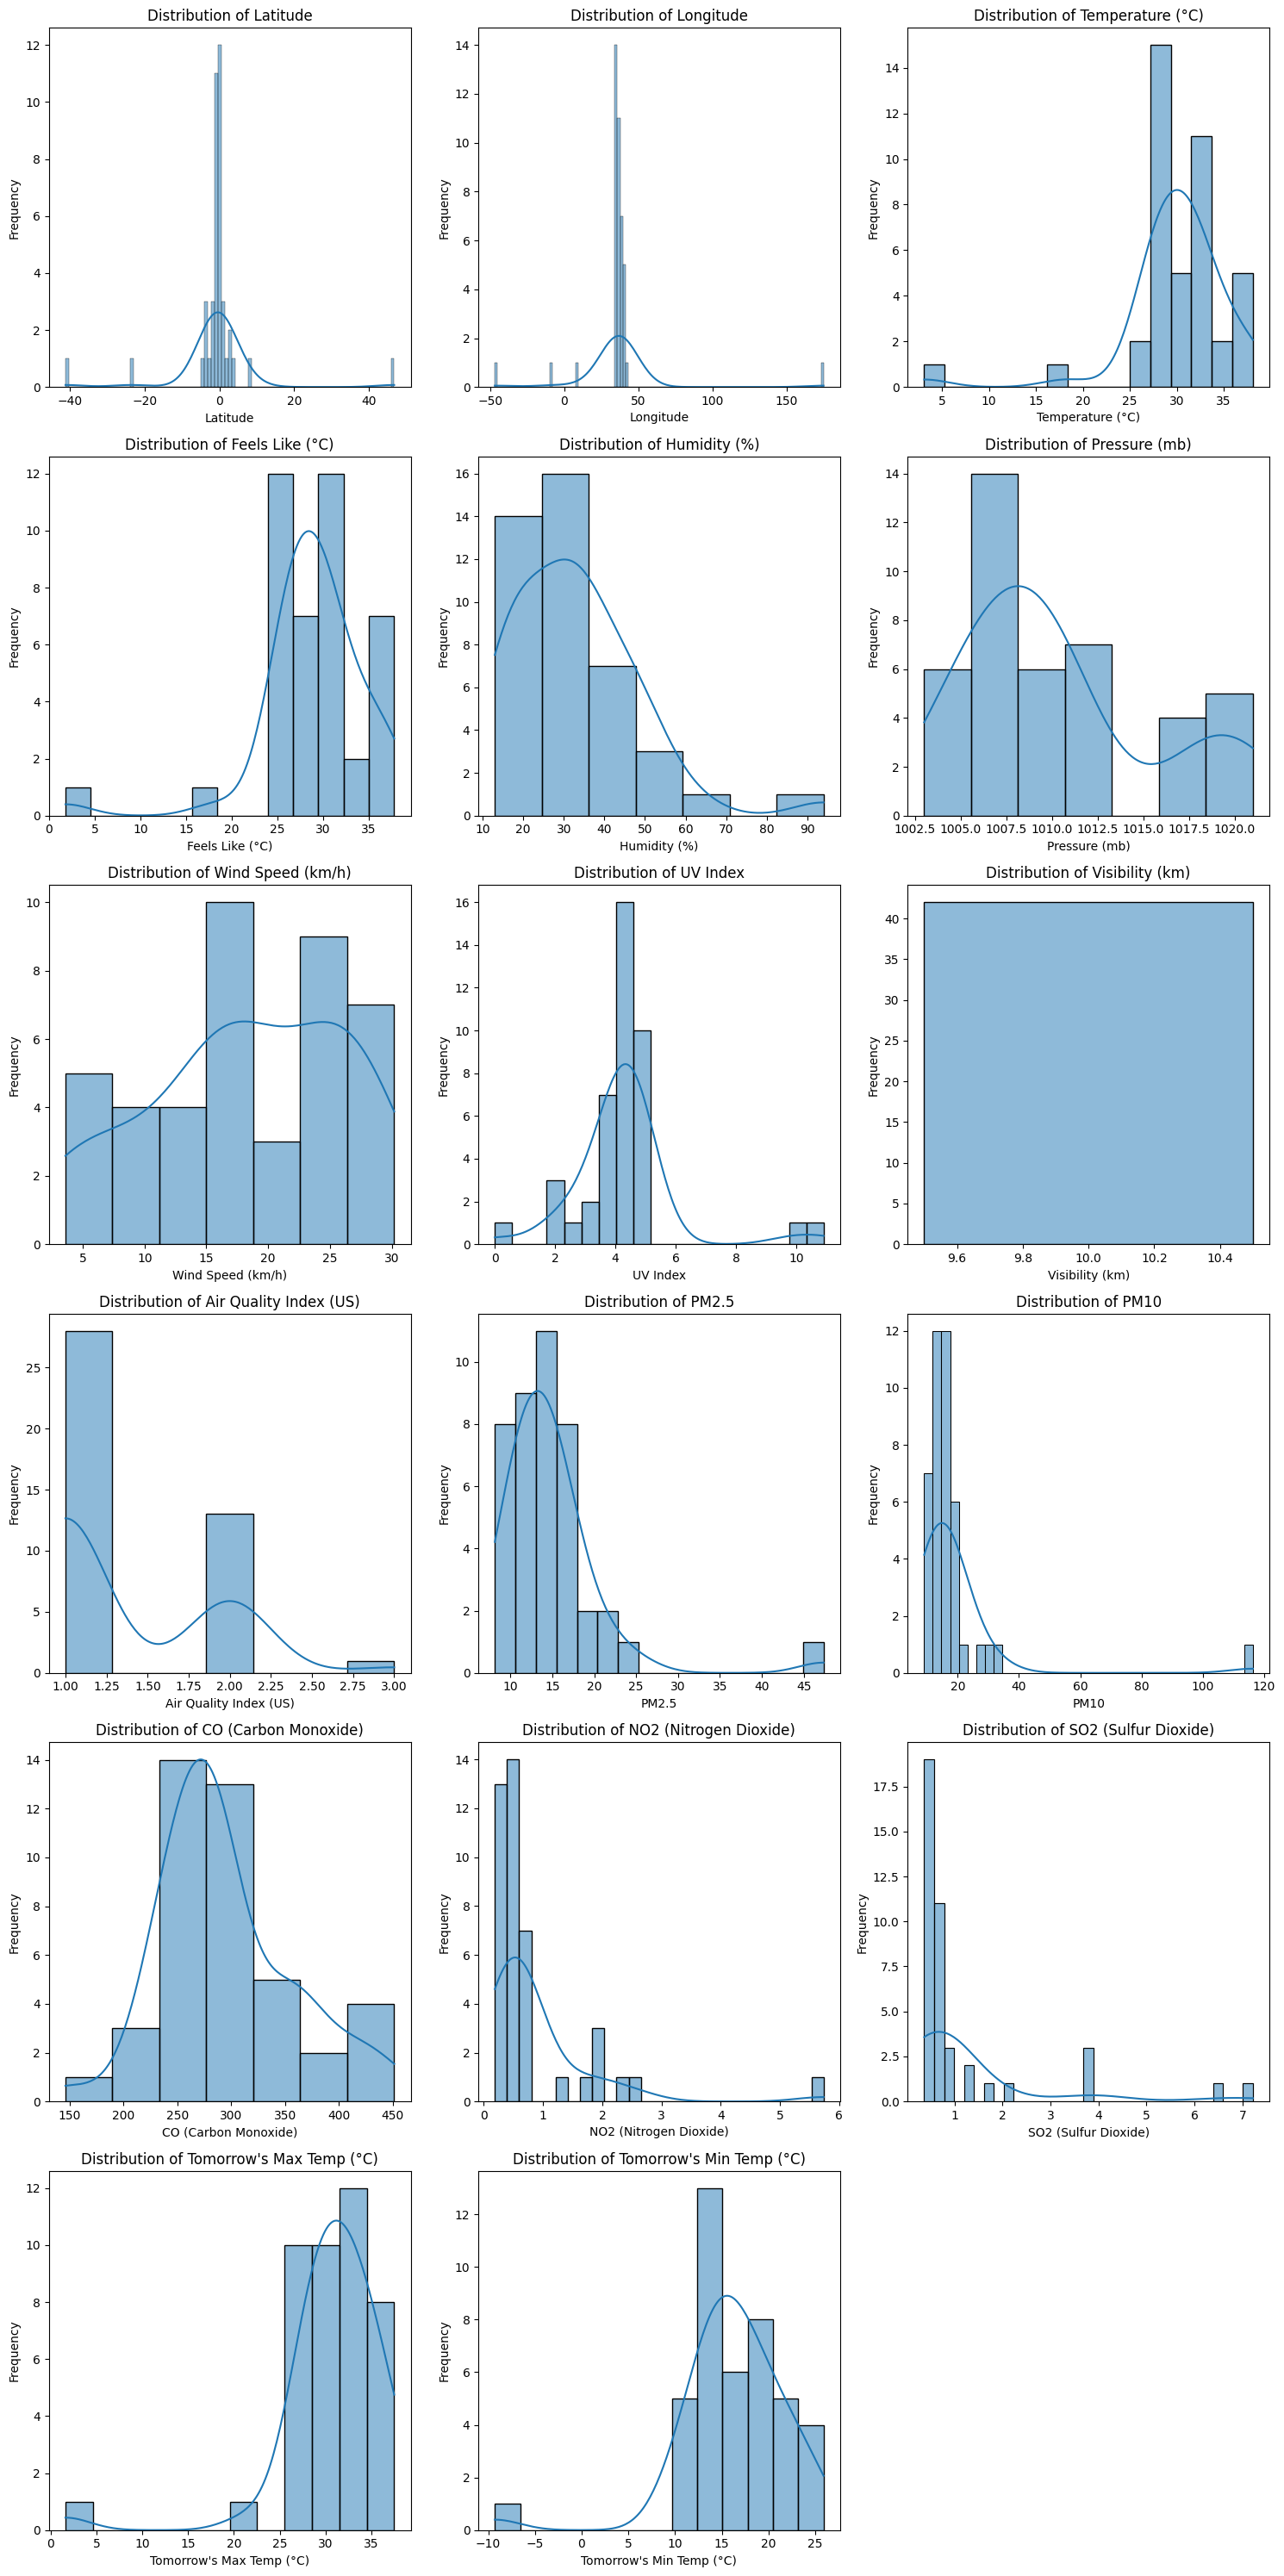

In [425]:
# Number of numerical features
num_features = len(df.select_dtypes(include=['float64', 'int64']).columns)

# Determine the number of rows and columns for the subplots
num_cols = 3
num_rows = math.ceil(num_features / num_cols)

# Plotting the distribution of numerical features
plt.figure(figsize=(15, 5 * num_rows))
for i, col in enumerate(df.select_dtypes(include=['float64', 'int64']).columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()

plt.show()


<ipython-input-426-98f79b260d75>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.



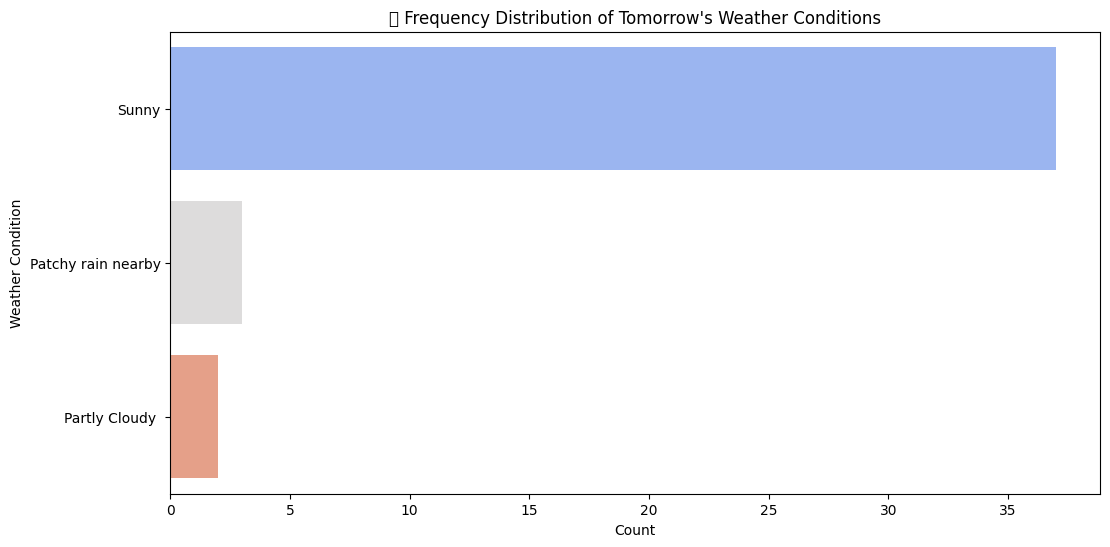

In [426]:
# 🔹 Plot Bar Chart for Tomorrow's Weather Condition
plt.figure(figsize=(12, 6))
sns.countplot(y=df["Tomorrow's Condition"], order=df["Tomorrow's Condition"].value_counts().index, palette="coolwarm")
plt.xlabel("Count")
plt.ylabel("Weather Condition")
plt.title("📌 Frequency Distribution of Tomorrow's Weather Conditions")
plt.show()

In [427]:
# Select only numeric columns (int64 and float64)
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Compute correlation with 'UV Index'
uv_corr = numeric_df.corr()['UV Index']

# Display correlations
print(uv_corr)


Latitude                   -0.002886
Longitude                  -0.712574
Temperature (°C)            0.290017
Feels Like (°C)             0.273285
Humidity (%)               -0.260949
Pressure (mb)               0.354787
Wind Speed (km/h)          -0.106624
UV Index                    1.000000
Visibility (km)                  NaN
Air Quality Index (US)      0.190368
PM2.5                       0.420053
PM10                        0.525695
CO (Carbon Monoxide)        0.491184
NO2 (Nitrogen Dioxide)      0.285854
SO2 (Sulfur Dioxide)        0.335803
Tomorrow's Max Temp (°C)    0.281475
Tomorrow's Min Temp (°C)    0.138498
Name: UV Index, dtype: float64


In [428]:
df['Weather Condition'].value_counts()

,count
Weather Condition,
Partly cloudy,26
Sunny,11
Partly Cloudy,3
Patchy rain nearby,1
Clear,1


# **Visualizations**

In [429]:
import folium
from folium.plugins import HeatMap
import pandas as pd

# Create a map centered around Kenya
m = folium.Map(location=[0.0236, 37.9062], zoom_start=6)

# Prepare data for the heat map
heat_data = [[row['Latitude'], row['Longitude'], row['Temperature (°C)']] for index, row in df.iterrows()]

# Add the heat map
HeatMap(heat_data).add_to(m)

# Add markers to the map
for index, row in df.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"Temperature: {row['Temperature (°C)']}°C",
        icon=folium.Icon(color='blue')
    ).add_to(m)

# Save to an HTML file
m.save('kenya_temperature_heatmap.html')

# Display the map
m


In [430]:
# 🔹 Geospatial Map of Cities
fig = px.scatter_mapbox(df, lat="Latitude", lon="Longitude", color="Temperature (°C)", size="Wind Speed (km/h)", mapbox_style="open-street-map", title="🌎 Temperature Across Kenya")
fig.show()

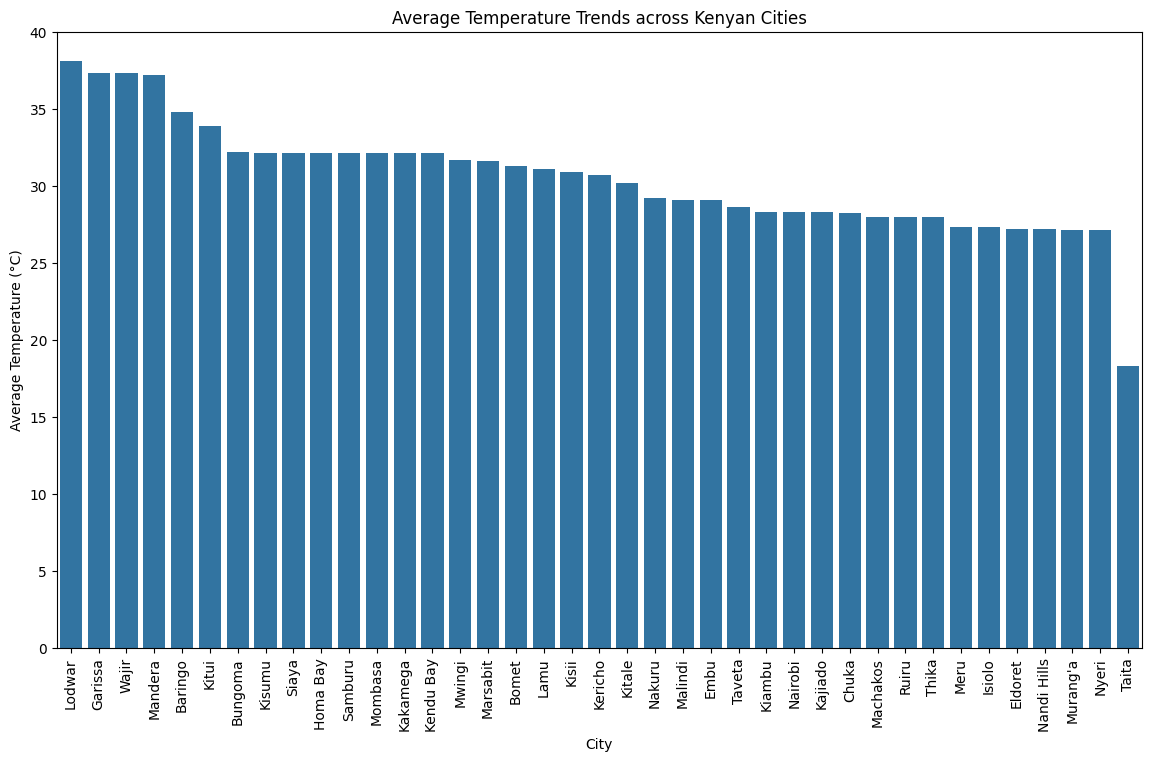

In [431]:
# Filter the DataFrame to include only the specified cities
df_filtered = df[df['City'].isin(kenyan_cities)]

# Calculate the average temperature for each city
avg_temp_by_city = df_filtered.groupby('City')['Temperature (°C)'].mean().reset_index()

# Sort the DataFrame by temperature in descending order
avg_temp_by_city = avg_temp_by_city.sort_values(by='Temperature (°C)', ascending=False)

# Vertical Bar Graph for Temperature Trends across Kenyan Cities
plt.figure(figsize=(14, 8))
sns.barplot(x='City', y='Temperature (°C)', data=avg_temp_by_city)
plt.title('Average Temperature Trends across Kenyan Cities')
plt.xlabel('City')
plt.ylabel('Average Temperature (°C)')
plt.xticks(rotation=90)
plt.show()

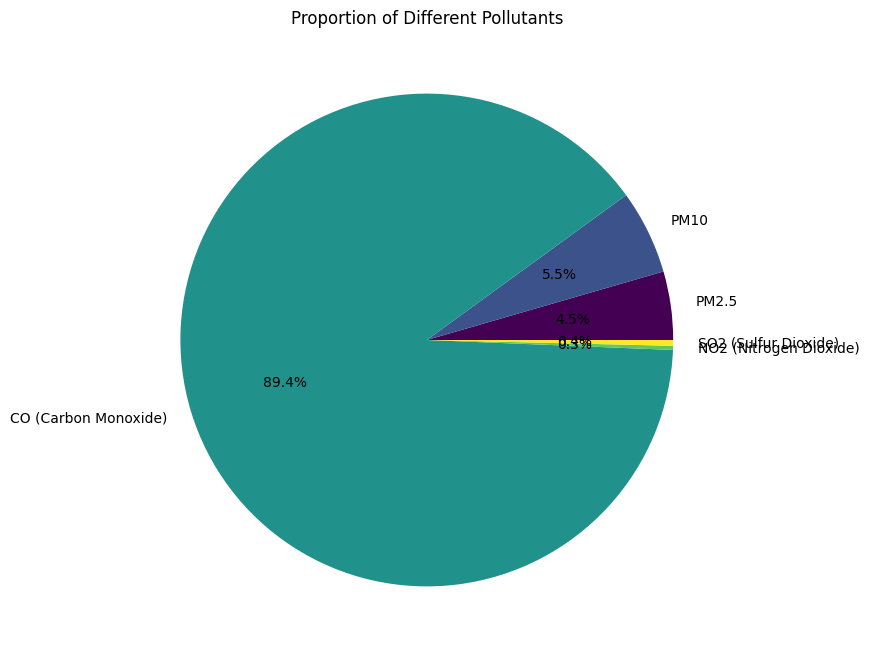

In [432]:
# Pie Chart for Pollutants
pollutants = ['PM2.5', 'PM10', 'CO (Carbon Monoxide)', 'NO2 (Nitrogen Dioxide)', 'SO2 (Sulfur Dioxide)']
pollutant_totals = df[pollutants].mean()

plt.figure(figsize=(8, 8))
plt.pie(pollutant_totals, labels=pollutants, autopct='%1.1f%%', colors=cm.viridis(np.linspace(0, 1, len(pollutants))))
plt.title('Proportion of Different Pollutants')
plt.show()

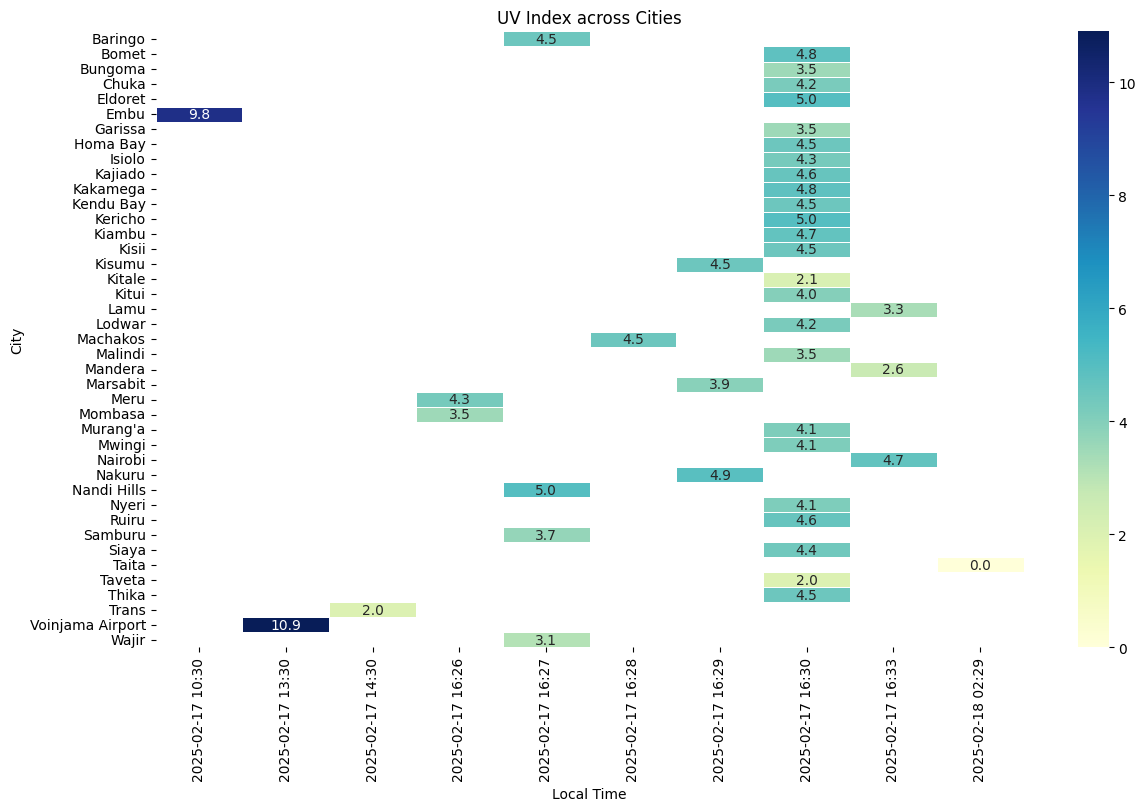

In [433]:

# Create a pivot table for the heatmap
pivot_table = df.pivot_table(values='UV Index', index='City', columns='Local Time', aggfunc='mean')

# Heatmap for UV Index across Cities
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt=".1f", linewidths=0.5)
plt.title('UV Index across Cities')
plt.xlabel('Local Time')
plt.ylabel('City')
plt.xticks(rotation=90)
plt.show()


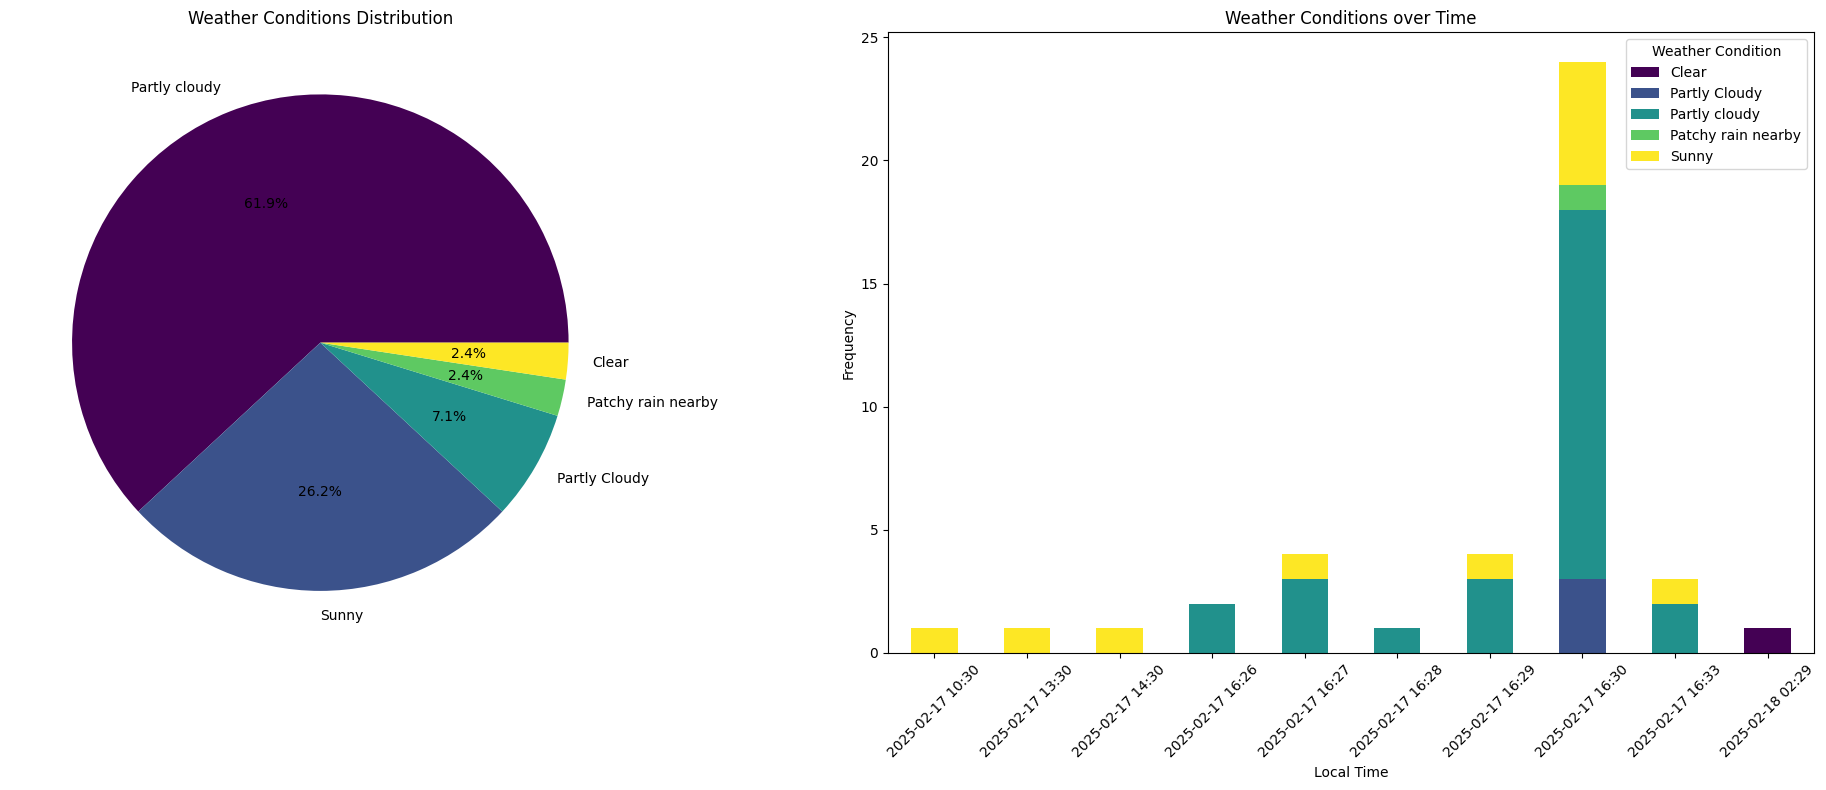

In [434]:
# Pie Chart for Weather Conditions
weather_conditions = df['Weather Condition'].value_counts()

# Stacked Bar Chart for Weather Conditions over Time
weather_time = pd.crosstab(df['Local Time'], df['Weather Condition'])

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Pie Chart
axes[0].pie(weather_conditions, labels=weather_conditions.index, autopct='%1.1f%%',
            colors=plt.cm.viridis(np.linspace(0, 1, len(weather_conditions))))
axes[0].set_title('Weather Conditions Distribution')

# Stacked Bar Chart for Weather Conditions over Time
weather_time.plot(kind='bar', stacked=True, ax=axes[1], colormap='viridis')
axes[1].set_title('Weather Conditions over Time')
axes[1].set_xlabel('Local Time')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Weather Condition')

plt.tight_layout()
plt.show()


**correlation Heatmap**

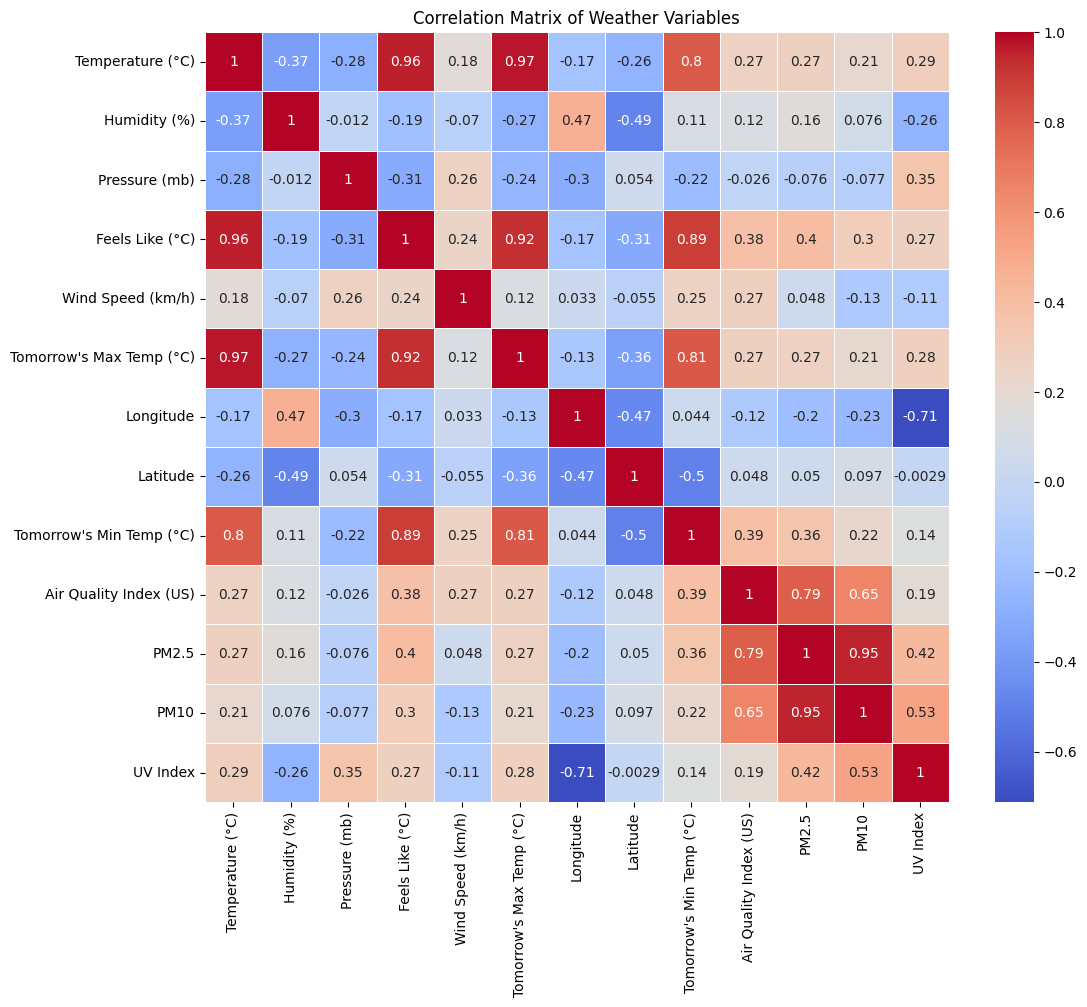

In [435]:

# Define relevant columns
col = [
    'Temperature (°C)', 'Humidity (%)', 'Pressure (mb)', 'Feels Like (°C)',
    'Wind Speed (km/h)', "Tomorrow's Max Temp (°C)","Longitude","Latitude",
    "Tomorrow's Min Temp (°C)","Air Quality Index (US)","PM2.5","PM10", "UV Index"
]

# Apply preprocessing to numerical columns for correlation analysis
numerical_data = df[col]  # Select numerical data

numerical_transformer = StandardScaler()  # Initialize scaler
numerical_data_scaled = numerical_transformer.fit_transform(numerical_data)  # Scale data

# Convert scaled data back into a DataFrame
numerical_data_scaled_df = pd.DataFrame(numerical_data_scaled, columns=col)

# Calculate the correlation matrix
correlation_matrix = numerical_data_scaled_df.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Weather Variables')
plt.show()


# **Data Pre-processing**

In [436]:
# make a copy of the df
df_copy = df.copy()
df_copy1=df_copy.copy()

In [437]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

# List of columns to drop (including "Weather Condition")
columns_to_drop = [
    "City","Country", "Local Time", "Visibility (km)", "Weather Condition", "Tomorrow's Condition", "Wind Direction", "Longitude", "Latitude"
]

# Drop unnecessary columns
df_copy.drop(columns=columns_to_drop, inplace=True)

# Convert 'Sunrise' and 'Sunset' to numerical features (minutes since midnight)
df_copy['Sunrise'] = pd.to_datetime(df_copy['Sunrise'], format='%I:%M %p').dt.hour * 60 + pd.to_datetime(df_copy['Sunrise'], format='%I:%M %p').dt.minute
df_copy['Sunset'] = pd.to_datetime(df_copy['Sunset'], format='%I:%M %p').dt.hour * 60 + pd.to_datetime(df_copy['Sunset'], format='%I:%M %p').dt.minute



# Reset index
df_copy.reset_index(drop=True, inplace=True)

# Separate target variable
uv_index = df_copy[['UV Index']]

# Normalize humidity, air quality, PM2.5, PM10, CO, NO2, SO2, Temperature, Feels Like, Min Temperature, Max Temperature (excluding 'UV Index')

# Standardize wind speed
feature_scaler = StandardScaler()
scaled_features = feature_scaler.fit_transform(df_copy.drop(columns=['UV Index']))

# Normalize the target variable
target_scaler = StandardScaler()
scaled_target = target_scaler.fit_transform(uv_index)

# Convert scaled features back to a DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=df_copy.columns[df_copy.columns != 'UV Index'])

# Add scaled 'UV Index' back
scaled_df['UV Index'] = scaled_target


**Creating sequences for the LSTM model**

In [438]:
# Define a function to create sequences
def create_sequences(data, target_column, seq_length=30):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i+seq_length].drop(columns=[target_column]).values
        target = data.iloc[i+seq_length][target_column]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Create sequences for LSTM
seq_length = 30
X, y = create_sequences(df_copy, 'UV Index', seq_length)



In [439]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Temperature (°C)          42 non-null     float64
 1   Feels Like (°C)           42 non-null     float64
 2   Humidity (%)              42 non-null     int64  
 3   Pressure (mb)             42 non-null     float64
 4   Wind Speed (km/h)         42 non-null     float64
 5   UV Index                  42 non-null     float64
 6   Air Quality Index (US)    42 non-null     int64  
 7   PM2.5                     42 non-null     float64
 8   PM10                      42 non-null     float64
 9   CO (Carbon Monoxide)      42 non-null     float64
 10  NO2 (Nitrogen Dioxide)    42 non-null     float64
 11  SO2 (Sulfur Dioxide)      42 non-null     float64
 12  Tomorrow's Max Temp (°C)  42 non-null     float64
 13  Tomorrow's Min Temp (°C)  42 non-null     float64
 14  Sunrise     

**Train-Test split**

In [440]:
# Split data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



# **Modelling**

**LSTM**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 16.5059 - val_loss: 12.4859 - learning_rate: 1.0000e-04
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 15.6898 - val_loss: 11.7483 - learning_rate: 1.0000e-04
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - loss: 13.9141 - val_loss: 11.0393 - learning_rate: 1.0000e-04
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step - loss: 14.1327 - val_loss: 10.3735 - learning_rate: 1.0000e-04
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 12.7582 - val_loss: 9.7552 - learning_rate: 1.0000e-04
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 12.0517 - val_loss: 9.2100 - learning_rate: 1.0000e-04
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 10.7997 - val_loss: 8.6470 - learning_rate: 1.0000e-04
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step - loss: 11.1437 - val_loss: 8.1041 - learning_rate: 1.0000e-04
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step - loss: 9.9289 - val_loss: 7.5302 - 

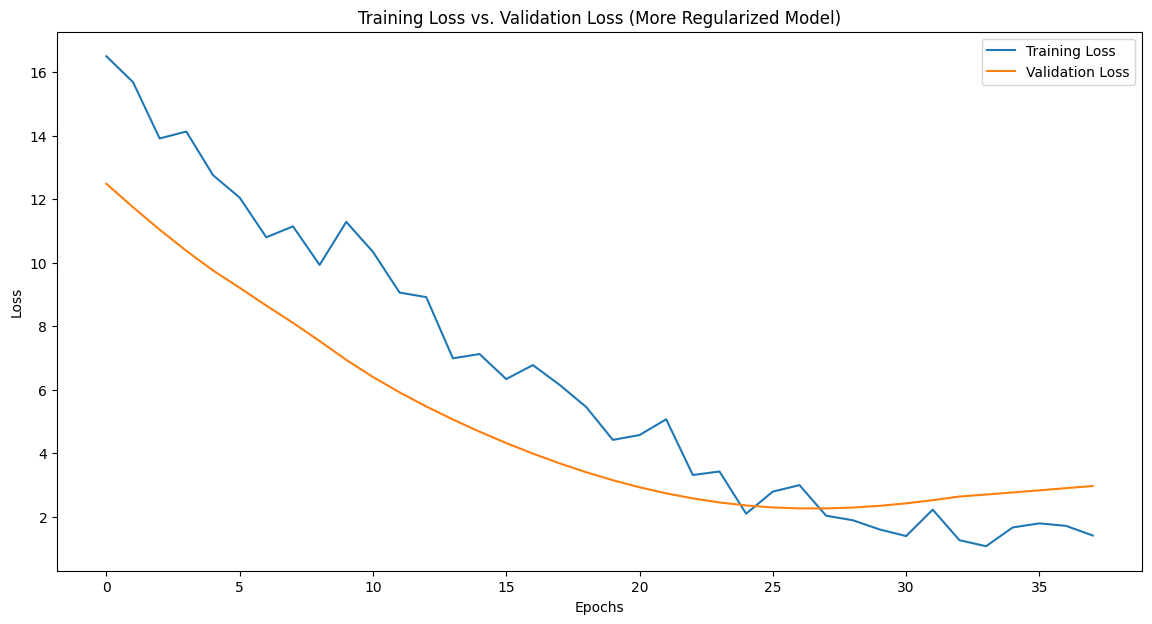

In [441]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# Build an improved LSTM model
model = Sequential()
model.add(LSTM(128, activation='tanh', input_shape=(seq_length, X.shape[2]), return_sequences=True, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))  # Increased dropout
model.add(LSTM(128, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.001)))  # Added another LSTM layer with return_sequences=True
model.add(Dropout(0.5))  # Increased dropout
model.add(LSTM(128, activation='tanh', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))  # Increased dropout
model.add(Dense(1, activation='linear'))

# Set learning rate inside optimizer
optimizer = Adam(learning_rate=0.0001)  # Reduced learning rate
model.compile(optimizer=optimizer, loss='mse')

# Train with early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

history = model.fit(X_train, y_train, epochs=200, batch_size=16, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

# Evaluate the model
mse = model.evaluate(X_test, y_test)
print(f'Test Mean Squared Error: {mse}')

# Make predictions
y_pred = model.predict(X_test)

# Plot training loss vs. validation loss
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training Loss vs. Validation Loss (More Regularized Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [446]:
# save my model above so i can use it on streamlit
model.save("LSTM_model.keras")


**Hyperparameter Tuning using Randomized Search**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 15.8834 - val_loss: 13.3253 - learning_rate: 0.0010
Epoch 2/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 21.6111 - val_loss: 13.2627 - learning_rate: 0.0010
Epoch 3/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 26.3423 - val_loss: 13.1665 - learning_rate: 0.0010
Epoch 4/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 19.7175 - val_loss: 13.0586 - learning_rate: 0.0010
Epoch 5/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 19.1874 - val_loss: 12.9094 - learning_rate: 0.0010
Epoch 6/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 14.8408 - val_loss: 12.7604 - learning_rate: 0.0010
Epoch 7/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 19.0579 - val_loss: 12.6398 - learning_rate: 0.0010
Epoch 8/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 22.0628 - val_loss: 12.5016 - learning_rate: 0.0010
Epoch 9/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 24.0501 - val_loss: 12.3422 - learning_rate: 0.0010
Ep

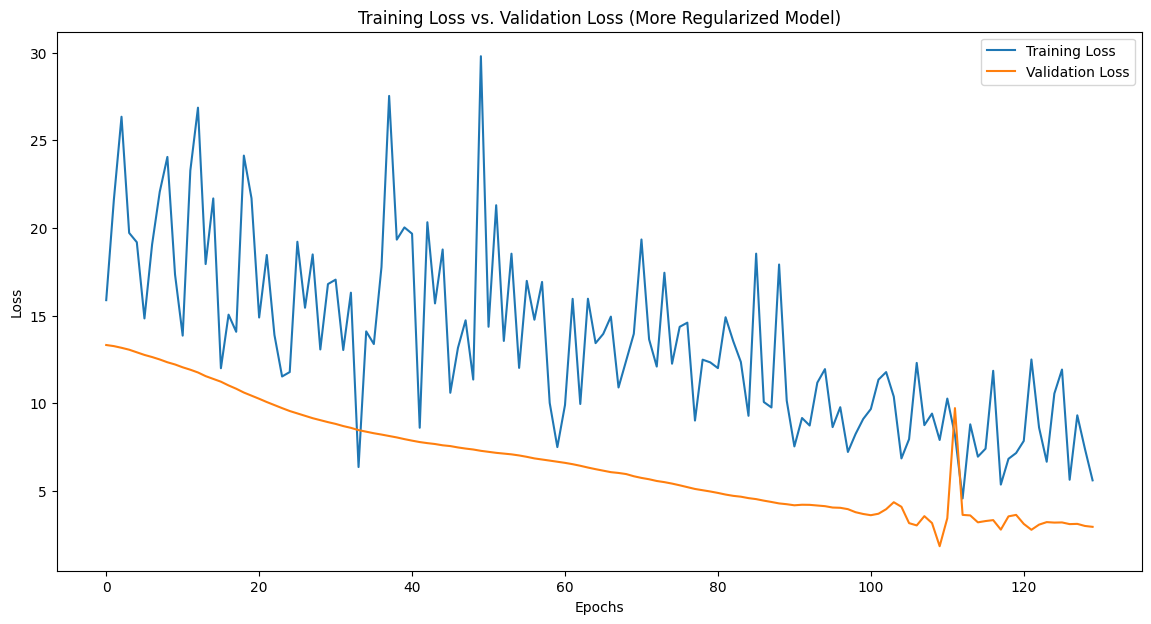

In [445]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Scale the input data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Define the function to build the model
def build_lstm_model(optimizer='adam', units=200, dropout_rate=0.5, activation='relu'):
    model = Sequential()

    # LSTM Layers with higher dropout and regularization
    model.add(LSTM(units, activation=activation, return_sequences=True, kernel_regularizer=l2(0.002), input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units, activation=activation, return_sequences=True, kernel_regularizer=l2(0.002)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units, activation=activation, kernel_regularizer=l2(0.002)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # Dense output layer
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=optimizer, loss='mse')
    return model

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

# Define the Custom KerasRegressor
class KerasRegressorCustom(BaseEstimator, RegressorMixin):
    def __init__(self, build_fn=None, optimizer='adam', units=200, dropout_rate=0.5, activation='relu', epochs=400, batch_size=16):
        self.build_fn = build_fn
        self.optimizer = optimizer
        self.units = units
        self.dropout_rate = dropout_rate
        self.activation = activation
        self.epochs = epochs
        self.batch_size = batch_size

    def fit(self, X, y, **kwargs):
        self.model = self.build_fn(optimizer=self.optimizer, units=self.units,
                                   dropout_rate=self.dropout_rate, activation=self.activation)
        self.history = self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size,
                                      validation_split=0.2, callbacks=[early_stopping, reduce_lr], verbose=1, **kwargs)
        return self

    def predict(self, X):
        return self.model.predict(X).flatten()

    def score(self, X, y):
        y_pred = self.predict(X)
        return -mean_squared_error(y, y_pred)

# Train the model
best_model = KerasRegressorCustom(build_fn=build_lstm_model, epochs=400, batch_size=16)
best_model.fit(X_train_scaled, y_train)

# Predict
y_pred = best_model.predict(X_val_scaled)

# Evaluation
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

# Plot training vs validation loss
plt.figure(figsize=(14, 7))
plt.plot(best_model.history.history['loss'], label='Training Loss')
plt.plot(best_model.history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training Loss vs. Validation Loss (More Regularized Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [444]:
import csv
import random


# Function to recommend sunscreen based on UV index
def recommend_sunscreen(uv_index):
    if uv_index <= 2:
        spf_range = (15, 30)
    elif uv_index <= 5:
        spf_range = (30, 50)
    elif uv_index <= 7:
        spf_range = (50, 100)
    else:
        spf_range = (50, 100)

    # Filter sunscreens based on SPF range
    filtered_sunscreens = [s for s in sunscreens if spf_range[0] <= s["SPF"] <= spf_range[1]]

    return random.choice(filtered_sunscreens) if filtered_sunscreens else None

# Generate sunscreen recommendations for each predicted UV index
spf_recommendations = [recommend_sunscreen(uv) for uv in y_pred]

# Print the recommendations
for uv, rec in zip(y_pred, spf_recommendations):
    if rec:
        print(f"UV Index: {uv} -> Recommended Sunscreen: {rec['Sunscreen Name']} (SPF {rec['SPF']})")
    else:
        print(f"UV Index: {uv} -> No suitable sunscreen found.")


TypeError: string indices must be integers, not 'str'